In [305]:
!pip install keras
!pip install tensorflow

In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [307]:
data = pd.read_csv("VNM.csv", parse_dates=['Date'], dayfirst=False, thousands=',', decimal='.')
data

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-12-31,63400.0,63400.0,63800.0,63300.0,1.64M,0.16%
1,2024-12-30,63300.0,63600.0,63700.0,63300.0,1.49M,-0.78%
2,2024-12-27,63800.0,63900.0,64100.0,63700.0,2.44M,0.00%
3,2024-12-26,63800.0,64200.0,64200.0,63800.0,1.71M,-0.16%
4,2024-12-25,63900.0,63900.0,64396.1,63900.0,1.30M,0.16%
...,...,...,...,...,...,...,...
2863,2013-07-16,96528.0,95139.0,97222.0,95139.0,729.69K,1.46%
2864,2013-07-15,95139.0,95139.0,95833.0,94444.0,176.98K,0.00%
2865,2013-07-12,95139.0,94444.0,95139.0,93750.0,220.82K,0.74%
2866,2013-07-11,94444.0,94444.0,95139.0,93750.0,161.84K,0.00%


In [309]:
# Đổi tên các cột thành tiếng Anh cho dễ làm việc
data.rename(columns={
    "Price": "Close",
    "Vol.": "Volume",
}, inplace = True)
data

,Date,Close,Open,High,Low,Volume,Change %
0,2024-12-31,63400.0,63400.0,63800.0,63300.0,1.64M,0.16%
1,2024-12-30,63300.0,63600.0,63700.0,63300.0,1.49M,-0.78%
2,2024-12-27,63800.0,63900.0,64100.0,63700.0,2.44M,0.00%
3,2024-12-26,63800.0,64200.0,64200.0,63800.0,1.71M,-0.16%
4,2024-12-25,63900.0,63900.0,64396.1,63900.0,1.30M,0.16%
...,...,...,...,...,...,...,...
2863,2013-07-16,96528.0,95139.0,97222.0,95139.0,729.69K,1.46%
2864,2013-07-15,95139.0,95139.0,95833.0,94444.0,176.98K,0.00%
2865,2013-07-12,95139.0,94444.0,95139.0,93750.0,220.82K,0.74%
2866,2013-07-11,94444.0,94444.0,95139.0,93750.0,161.84K,0.00%


<Axes: >

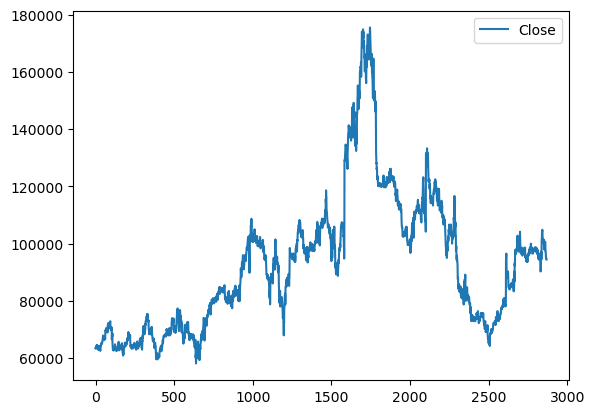

In [310]:
data.plot.line(y="Close", use_index = True)

In [311]:
#convert M L K trong cột KL thành số thực
def convert_volume(vol_str):
    if isinstance(vol_str, str):
        if vol_str[-1] == 'M':
            return float(vol_str[:-1]) * 1_000_000
        elif vol_str[-1] == 'K':
            return float(vol_str[:-1]) * 1_000
    return float(vol_str)

data['Volume'] = data['Volume'].apply(convert_volume)
data = data.sort_values('Date')
data = data.ffill()
data

,Date,Close,Open,High,Low,Volume,Change %
2867,2013-07-10,94444.0,95139.0,95833.0,94444.0,232110.0,0.00%
2866,2013-07-11,94444.0,94444.0,95139.0,93750.0,161840.0,0.00%
2865,2013-07-12,95139.0,94444.0,95139.0,93750.0,220820.0,0.74%
2864,2013-07-15,95139.0,95139.0,95833.0,94444.0,176980.0,0.00%
2863,2013-07-16,96528.0,95139.0,97222.0,95139.0,729690.0,1.46%
...,...,...,...,...,...,...,...
4,2024-12-25,63900.0,63900.0,64396.1,63900.0,1300000.0,0.16%
3,2024-12-26,63800.0,64200.0,64200.0,63800.0,1710000.0,-0.16%
2,2024-12-27,63800.0,63900.0,64100.0,63700.0,2440000.0,0.00%
1,2024-12-30,63300.0,63600.0,63700.0,63300.0,1490000.0,-0.78%


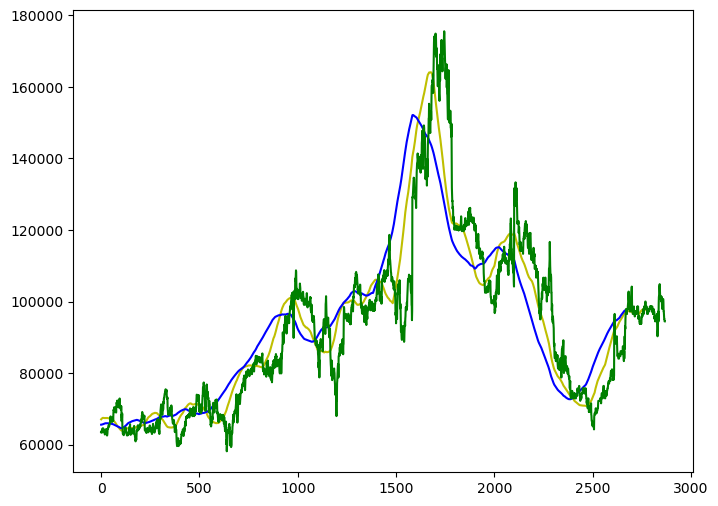

In [312]:
ma_100 = data.Close.rolling(100).mean()
ma_200 = data.Close.rolling(200).mean()

plt.figure(figsize=(8,6))
plt.plot(ma_100, 'y')
plt.plot(ma_200, 'b')
plt.plot(data.Close, 'g')
plt.show()

In [313]:
data.dropna(inplace=True)

In [314]:
data_train = pd.DataFrame(data.Close[0: int(len(data)*0.80)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])

In [315]:
data_train.shape[0]

2294

In [316]:
data_test.shape[0]

574

In [317]:
scaler = MinMaxScaler(feature_range=(0,1))

In [318]:
data_train_scale = scaler.fit_transform(data_train)

In [319]:
x = []
y = []

for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])

In [320]:
x, y = np.array(x), np.array(y)

In [321]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,
               input_shape = ((x.shape[1],1))))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation='relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units =1))

D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [322]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [323]:
model.fit(x,y, epochs = 50, batch_size =32, verbose =1)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - loss: 0.0599
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - loss: 0.0081
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - loss: 0.0076
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0060
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.0059
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - loss: 0.0054
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - loss: 0.0047
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.0045
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - loss: 0.0050
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.0050
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - loss: 0.0045
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 0.0037
Epoch 13/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.0038
Epoch 14/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 0.0036
Epoch 15/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - l

In [324]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,285 (2.05 MB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 357,524 (1.36 MB)

In [325]:
pas_100_days = data_train.tail(100)

In [326]:
data_test = pd.concat([pas_100_days, data_test], ignore_index=True)

In [327]:
data_test_scale  =  scaler.fit_transform(data_test)

In [328]:
x = []
y = []

for i in range(100, data_test_scale.shape[0]):
    x.append(data_test_scale[i-100:i])
    y.append(data_test_scale[i,0])
x, y = np.array(x), np.array(y)

In [329]:
y_predict = model.predict(x)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step 


In [330]:
scale =1/scaler.scale_

In [331]:
y_predict = y_predict*scale

In [332]:
y = y*scale

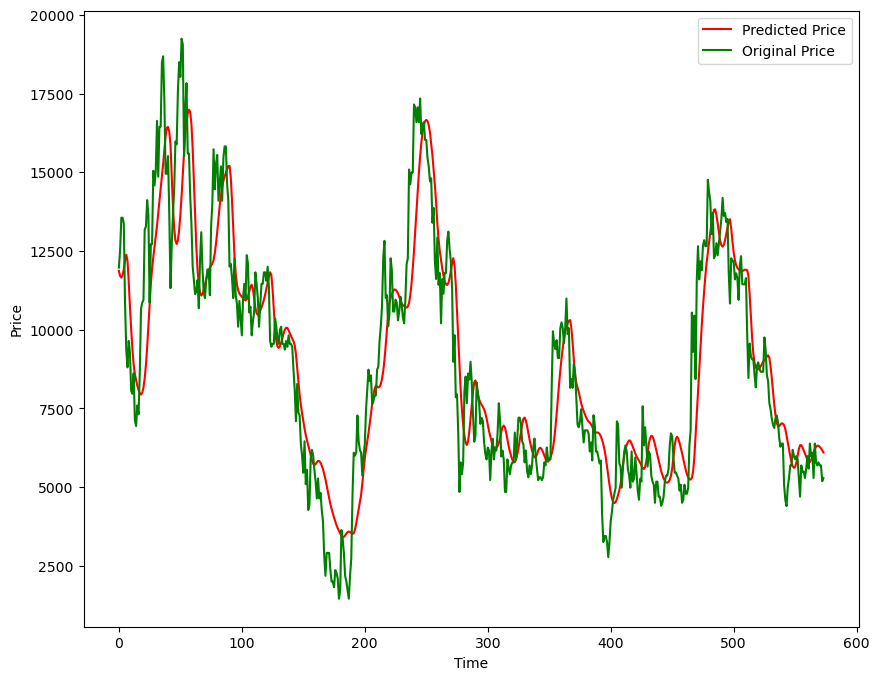

In [333]:
plt.figure(figsize=(10,8))
plt.plot(y_predict, 'r', label = 'Predicted Price')
plt.plot(y, 'g', label = 'Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [334]:
model.save('Predictors.keras')